In [1]:
import pickle

# PyMC for Bayesian Inference
import pymc as pm
import arviz as az
import bambi as bmb
print(f"Running on PyMC v{pm.__version__}")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Scikit-learn utilities
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, fbeta_score, f1_score, recall_score, precision_score, precision_recall_curve, roc_auc_score

# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Running on PyMC v5.10.0


In [2]:
# read standardised training dataset
df = pd.read_csv('data/HI-Small_Trans_processed_w_original_train.csv')
df.head()

,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,From Bank,To Bank,Account,Account.1,Receiving Currency,Payment Currency,Payment Format,Is Laundering
0,2022-09-01 00:20:00,6530,6530,8,8,12,12,5,3697.34,3697.34,10,10,8000EBD30,8000EBD30,US Dollar,US Dollar,Reinvestment,0
1,2022-09-01 00:20:00,358174,176809,109,0,12,12,3,0.01,0.01,3208,1,8000F4580,8000F5340,US Dollar,US Dollar,Cheque,0
2,2022-09-01 00:00:00,358476,358476,110,110,12,12,5,14675.57,14675.57,3209,3209,8000F4670,8000F4670,US Dollar,US Dollar,Reinvestment,0
3,2022-09-01 00:02:00,74640,74640,10,10,12,12,5,2806.97,2806.97,12,12,8000F5030,8000F5030,US Dollar,US Dollar,Reinvestment,0
4,2022-09-01 00:06:00,6538,6538,8,8,12,12,5,36682.97,36682.97,10,10,8000F5200,8000F5200,US Dollar,US Dollar,Reinvestment,0


### Data Processing & Feature Engineering

In [3]:
# Drop features
df = df.drop(columns=[
    'From Bank',
    'To Bank',
    'Account',
    'Account.1',
    'Payment Format'
])

df.head()

,Timestamp,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,Receiving Currency,Payment Currency,Is Laundering
0,2022-09-01 00:20:00,6530,6530,8,8,12,12,5,3697.34,3697.34,US Dollar,US Dollar,0
1,2022-09-01 00:20:00,358174,176809,109,0,12,12,3,0.01,0.01,US Dollar,US Dollar,0
2,2022-09-01 00:00:00,358476,358476,110,110,12,12,5,14675.57,14675.57,US Dollar,US Dollar,0
3,2022-09-01 00:02:00,74640,74640,10,10,12,12,5,2806.97,2806.97,US Dollar,US Dollar,0
4,2022-09-01 00:06:00,6538,6538,8,8,12,12,5,36682.97,36682.97,US Dollar,US Dollar,0


In [4]:
# additional feature pre-processing

# Split Timestamp column into MM, DD, HH etc. (Ignore dt columns with constant values - Year, Month, Second)
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# # df['Year'] = df['Timestamp'].dt.year
# # df['Month'] = df['Timestamp'].dt.month
# df['Day'] = df['Timestamp'].dt.day
# df['Hour'] = df['Timestamp'].dt.hour
# df['Minute'] = df['Timestamp'].dt.minute
# df['Second'] = df['Timestamp'].dt.second

In [5]:
# Standardise "Amount Paid" & "Amount Received" columns to USD denomination
ex_rates = {
    'Australian Dollar': 1.4958,
    'Bitcoin': 1/20201.19,
    'Brazil Real': 5.2299,
    'Canadian Dollar': 1.3316,
    'Euro': 1.009,
    'Mexican Peso': 20.055,
    'Ruble': 60.0435,
    'Rupee': 80.2343,
    'Saudi Riyal': 3.7598,
    'Shekel': 3.4489,
    'Swiss Franc': 0.973,
    'UK Pound': 0.836,
    'US Dollar': 1.0,
    'Yen': 143.0069,
    'Yuan': 7.0144,
}

df['AmountReceivedUSD'] = df['AmountReceived']
df['AmountPaidUSD'] = df['AmountPaid']

for currency, rate in ex_rates.items():
    print(f"{currency}: {rate}")
    mask = df['Receiving Currency'] == currency
    df.loc[mask, 'AmountReceivedUSD'] /= rate
    mask = df['Payment Currency'] == currency
    df.loc[mask, 'AmountPaidUSD'] /= rate

df = df.drop(columns=['AmountPaid', 'AmountReceived', 'Receiving Currency', 'Payment Currency'])

Australian Dollar: 1.4958
Bitcoin: 4.950203428609899e-05
Brazil Real: 5.2299
Canadian Dollar: 1.3316
Euro: 1.009
Mexican Peso: 20.055
Ruble: 60.0435
Rupee: 80.2343
Saudi Riyal: 3.7598
Shekel: 3.4489
Swiss Franc: 0.973
UK Pound: 0.836
US Dollar: 1.0
Yen: 143.0069
Yuan: 7.0144


In [6]:
# categorical variables distribution

df['FromBank_prob'] = df.groupby('FromBank')['FromBank'].transform(lambda x : x.count()/len(df))
df['ToBank_prob'] = df.groupby('ToBank')['ToBank'].transform(lambda x : x.count()/len(df))
df['ReceivingCurrency_prob'] = df.groupby('ReceivingCurrency')['ReceivingCurrency'].transform(lambda x : x.count()/len(df))
df['PaymentCurrency_prob'] = df.groupby('PaymentCurrency')['PaymentCurrency'].transform(lambda x : x.count()/len(df))
df['PaymentFormat_prob'] = df.groupby('PaymentFormat')['PaymentFormat'].transform(lambda x : x.count()/len(df))

In [7]:
FromBank_prob_df = df[['FromBank','FromBank_prob']].drop_duplicates().sort_values(by='FromBank')
FromBank_dist = FromBank_prob_df['FromBank_prob'].to_numpy()
FromBank_dist

array([9.98732659e-03, 6.91562691e-03, 4.05968201e-03, ...,
       7.48282505e-07, 4.98855003e-07, 4.98855003e-07])

In [8]:
ToBank_prob_df = df[['ToBank','ToBank_prob']].drop_duplicates().sort_values(by='ToBank')
ToBank_dist = ToBank_prob_df['ToBank_prob'].to_numpy()
ToBank_dist

array([4.62987328e-03, 4.45776831e-03, 2.68783076e-03, ...,
       2.49427502e-07, 2.49427502e-07, 2.49427502e-07])

In [9]:
ReceivingCurrency_prob_df = df[['ReceivingCurrency','ReceivingCurrency_prob']].drop_duplicates().sort_values(by='ReceivingCurrency')
ReceivingCurrency_dist = ReceivingCurrency_prob_df['ReceivingCurrency_prob'].to_numpy()
ReceivingCurrency_dist

array([0.02730458, 0.03008195, 0.01422884, 0.02784983, 0.23082919,
       0.022003  , 0.03111633, 0.03789003, 0.01769538, 0.03862809,
       0.04709964, 0.03553893, 0.3686733 , 0.03091779, 0.04014311])

In [10]:
PaymentCurrency_prob_df = df[['PaymentCurrency','PaymentCurrency_prob']].drop_duplicates().sort_values(by='PaymentCurrency')
PaymentCurrency_dist = PaymentCurrency_prob_df['PaymentCurrency_prob'].to_numpy()
PaymentCurrency_dist

array([0.02689228, 0.02968212, 0.0140308 , 0.02753131, 0.22993499,
       0.02179123, 0.03058929, 0.03745204, 0.01746242, 0.03795364,
       0.04636433, 0.03541397, 0.37237082, 0.03065389, 0.04187688])

In [11]:
PaymentFormat_prob_df = df[['PaymentFormat','PaymentFormat_prob']].drop_duplicates().sort_values(by='PaymentFormat')
PaymentFormat_dist = PaymentFormat_prob_df['PaymentFormat_prob'].to_numpy()
PaymentFormat_dist

array([0.12213816, 0.0296901 , 0.09066365, 0.35683847, 0.24919329,
       0.1199886 , 0.03148773])

In [12]:
# # apply log transform on 'AmountPaidUSD' and 'AmountReceivedUSD' to reduce skew
# df['LogAmountPaidUSD'] = np.log10(df['AmountPaidUSD'])
# df['LogAmountReceivedUSD'] = np.log10(df['AmountReceivedUSD'])

# Compress features by finding difference between 'AmountPaidUSD' and 'AmountReceivedUSD' 
df['AmountDeltaUSD'] = df['AmountPaidUSD'] - df['AmountReceivedUSD']

In [13]:
# Benford's law: Add first leading digit from both "Amount Paid" & "Amount Received" columns
def get_first_digit(figure:float) -> int:
    exception_set = ('0','.','e','-')
    for char in str(figure):
        if char not in exception_set:
            return int(char)

df['LDAmountPaidUSD'] = df.apply(lambda x: get_first_digit(x['AmountPaidUSD']), axis=1)
df['LDAmountReceivedUSD'] = df.apply(lambda x: get_first_digit(x['AmountReceivedUSD']), axis=1)

[]

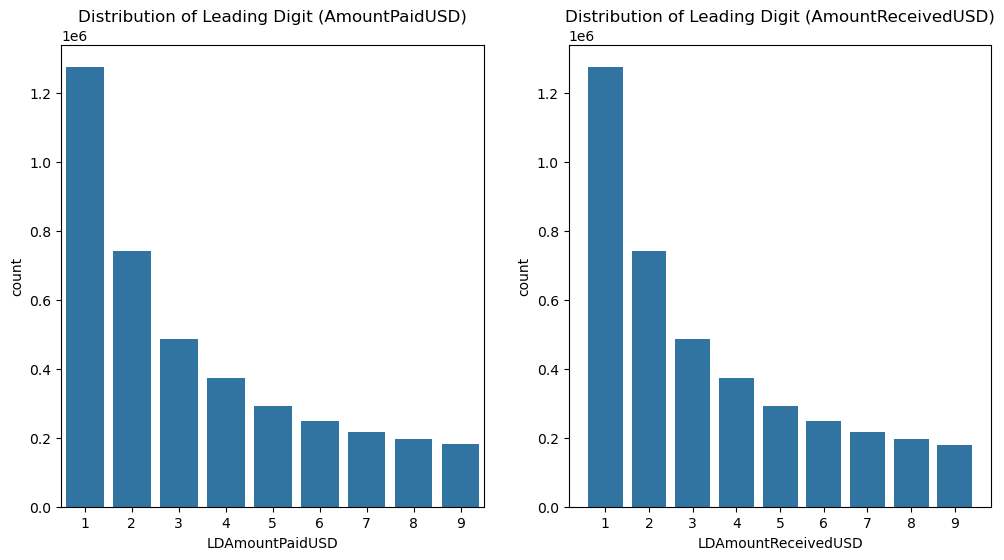

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x="LDAmountPaidUSD", data=df, ax=axes[0])
sns.countplot(x="LDAmountReceivedUSD", data=df, ax=axes[1])
axes[0].set_title('Distribution of Leading Digit (AmountPaidUSD)')
axes[1].set_title('Distribution of Leading Digit (AmountReceivedUSD)')
plt.plot()

In [15]:
df = df.drop(columns=[
    'FromAccount', 
    'ToAccount', 
    'Timestamp', 
    'FromBank_prob', 
    'ToBank_prob', 
    'PaymentCurrency_prob', 
    'ReceivingCurrency_prob', 
    'PaymentFormat_prob', 
    'AmountPaidUSD', 
    'AmountReceivedUSD'    
]).rename(columns={'Is Laundering':'IsLaundering'})
df.head()

,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,IsLaundering,AmountDeltaUSD,LDAmountPaidUSD,LDAmountReceivedUSD
0,8,8,12,12,5,0,0.0,3,3
1,109,0,12,12,3,0,0.0,1,1
2,110,110,12,12,5,0,0.0,1,1
3,10,10,12,12,5,0,0.0,2,2
4,8,8,12,12,5,0,0.0,3,3


In [16]:
features = df.drop(columns='IsLaundering')
labels = df['IsLaundering']

In [17]:
# apply stratified sampling to reduce dataset size
X, _, y, _ = train_test_split(features, labels, train_size=0.01, random_state=42, shuffle=True, stratify=labels)

print(X.shape)
print(y.shape)
y.value_counts()

(40091, 8)
(40091,)


IsLaundering
0    40050
1       41
Name: count, dtype: int64

In [18]:
# apply stratified sampling to reduce dataset size (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(y_train.shape)
y_train.value_counts()

(32072,)


IsLaundering
0    32039
1       33
Name: count, dtype: int64

In [19]:
# # undersampling majority class
# train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)],axis=1)
# class_counts = train_df['IsLaundering'].value_counts()
# df_majority = train_df[train_df['IsLaundering'] == 0]
# df_minority = train_df[train_df['IsLaundering'] == 1]
# df_majority_downsampled = resample(df_majority, replace=False, n_samples=class_counts[1])
# df_balanced = pd.concat([df_majority_downsampled, df_minority])
# X_train, y_train = df_balanced.iloc[:, :-1], df_balanced.iloc[:, [-1]]

In [20]:
# Create version of the training data with labels
X_with_labels = X_train.copy()
X_with_labels['IsLaundering'] = y_train
X_with_labels.describe()

,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountDeltaUSD,LDAmountPaidUSD,LDAmountReceivedUSD,IsLaundering
count,32072.000000,32072.000000,32072.000000,32072.000000,32072.000000,3.207200e+04,32072.000000,32072.000000,32072.000000
mean,2173.441694,2826.237341,8.365989,8.403280,3.062983,-6.533636e+02,3.329727,3.329384,0.001029
std,3826.739319,3140.685153,4.124705,4.125098,1.522500,1.028545e+05,2.445121,2.444765,0.032061
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.381933e+07,1.000000,1.000000,0.000000
25%,43.000000,567.000000,4.000000,4.000000,3.000000,0.000000e+00,1.000000,1.000000,0.000000
50%,632.000000,867.000000,10.000000,10.000000,3.000000,0.000000e+00,2.000000,2.000000,0.000000
75%,2491.000000,6152.000000,12.000000,12.000000,4.000000,0.000000e+00,5.000000,5.000000,0.000000
max,30459.000000,30459.000000,14.000000,14.000000,6.000000,2.164805e+06,9.000000,9.000000,1.000000


In [30]:
def get_predictions(model_predict, y_mean_label='IsLaundering_mean', threshold=0.7):

    # Get posterior mean across all chains and draws
    p = model_predict.posterior[y_mean_label].mean(("chain", "draw"))

    y_pred = [1 if i >= threshold else 0 for i in p]

    return y_pred

def plot_cm(y_test, y_pred, outfile=None):
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # cm = confusion_matrix(y_pred, y_test)
    
    # Create a Matplotlib figure
    fig, ax = plt.subplots(figsize=(6, 4.5))
    
    # Plot confusion matrix on the specified axis
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False,
                xticklabels=[0, 1],
                yticklabels=[0, 1], ax=ax)
    for pos in []:
        plt.gca().add_patch(plt.Rectangle(pos, 1, 1, fill=True, color='red', alpha=0.1))  # , edgecolor='red', lw=3))
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title(f"Confusion Matrix")
    if outfile is not None:
        plt.savefig(outfile)
    plt.show()
    plt.close()

### Bayesian Logistic Regression

#### Model 1 - Naive Model

In [24]:
# Build up a formula
formula = [' %s + ' % variable for variable in X_train.columns]
formula.insert(0, 'IsLaundering ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'IsLaundering ~  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountDeltaUSD +  LDAmountPaidUSD +  LDAmountReceivedUSD'

In [25]:
# Building of Bayesian Logistic Regression model
model = bmb.Model(formula, X_with_labels, family="bernoulli")
model

       Formula: IsLaundering ~  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountDeltaUSD +  LDAmountPaidUSD +  LDAmountReceivedUSD
        Family: bernoulli
          Link: p = logit
  Observations: 32072
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.6516)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0007)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6061)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.6061)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.6421)
            AmountDeltaUSD ~ Normal(mu: 0.0, sigma: 0.0)
            LDAmountPaidUSD ~ Normal(mu: 0.0, sigma: 1.0225)
            LDAmountReceivedUSD ~ Normal(mu: 0.0, sigma: 1.0226)

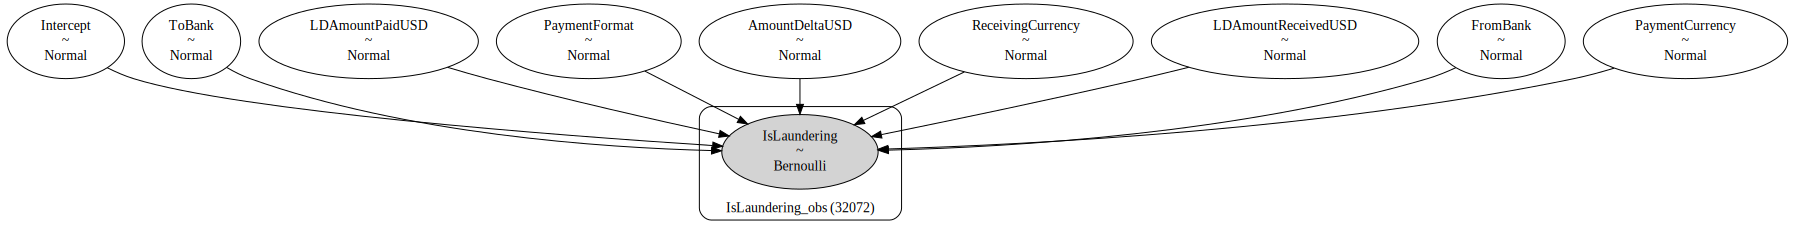

In [26]:
# Build model
model.build()
model.graph()

Sampling: [AmountDeltaUSD, FromBank, Intercept, LDAmountPaidUSD, LDAmountReceivedUSD, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToBank]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'ToBank'}>],
       [<Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentFormat'}>],
       [<Axes: title={'center': 'AmountDeltaUSD'}>,
        <Axes: title={'center': 'LDAmountPaidUSD'}>,
        <Axes: title={'center': 'LDAmountReceivedUSD'}>]], dtype=object)

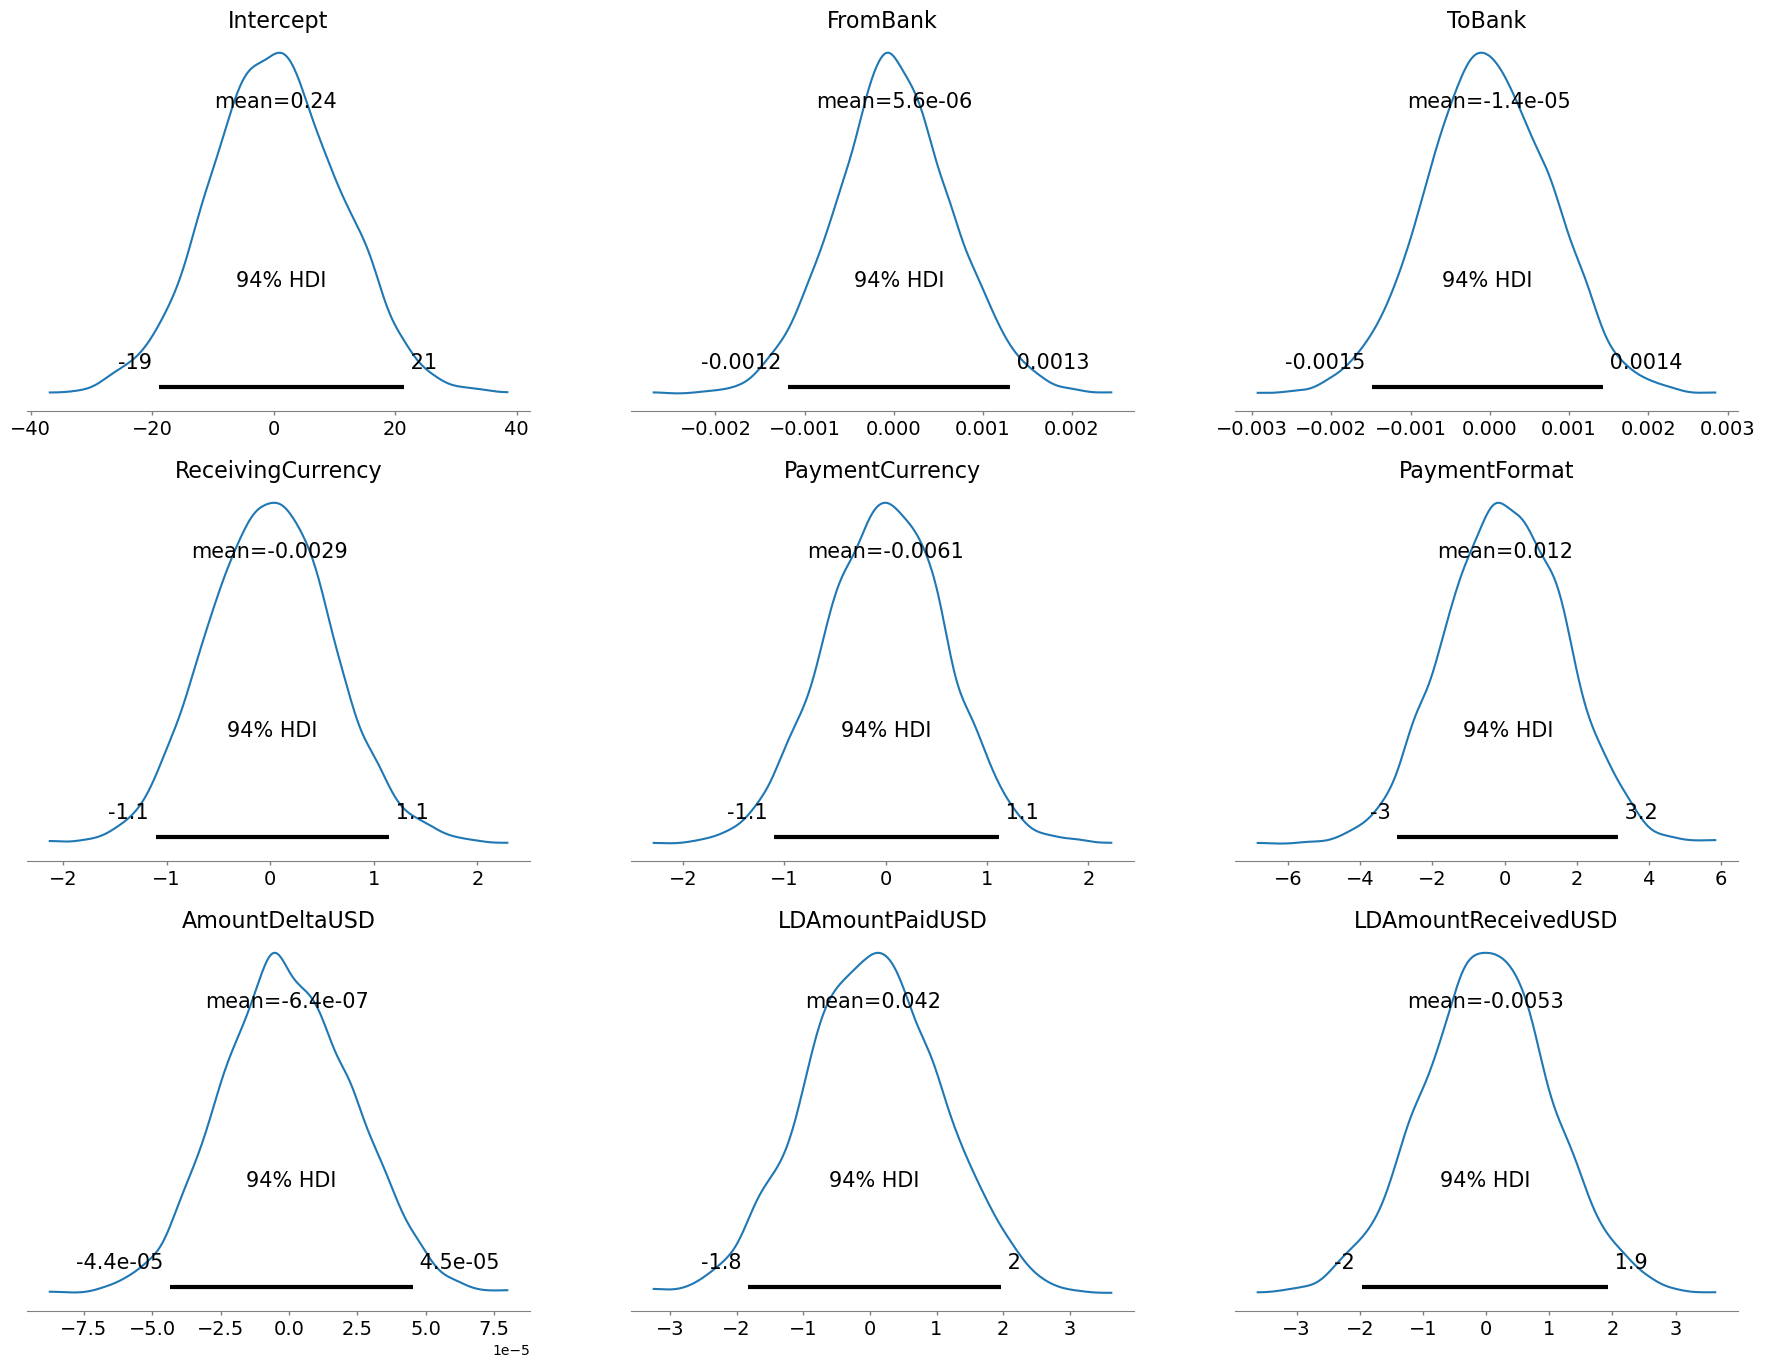

In [27]:
# Plot marginal priors of the built model
model.plot_priors()

In [26]:
# fit the model
# inference method = "vi" # variational inference
# inference method = "nuts_blackjax" # blackjax sampler
# results = model.fit(draws=1000, chains=2, inference_method='nuts_blackjax', idata_kwargs={"log_likelihood": True})
results = model.fit(draws=1000, chains=2, nuts_sampler='nutpie', idata_kwargs={"log_likelihood": True})
results

Modeling the probability that IsLaundering==1
/home/bernard/miniconda3/envs/pymc_env2/lib/python3.10/site-packages/pymc/sampling/mcmc.py:298: UserWarning: `idata_kwargs` are currently ignored by the nutpie sampler
  warnings.warn(


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

array([[<Axes: title={'center': 'AmountDeltaUSD'}>,
        <Axes: title={'center': 'AmountDeltaUSD'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'LDAmountPaidUSD'}>,
        <Axes: title={'center': 'LDAmountPaidUSD'}>],
       [<Axes: title={'center': 'LDAmountReceivedUSD'}>,
        <Axes: title={'center': 'LDAmountReceivedUSD'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'PaymentFormat'}>],
       [<Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ToBank'}>]], dtype=object)

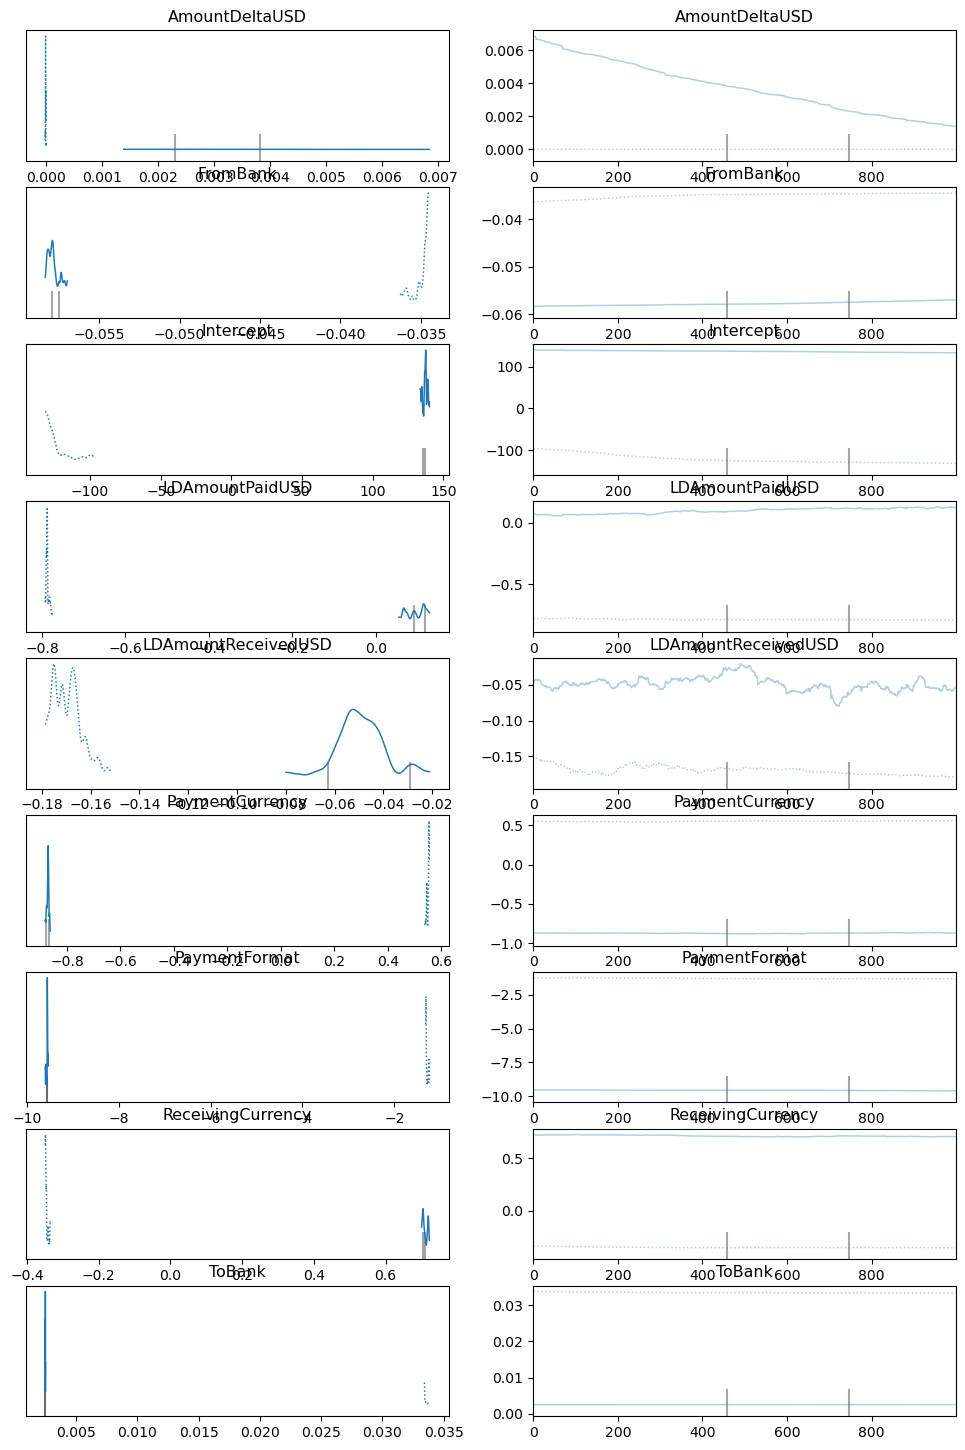

In [27]:
# traceplots and density estimates for the posteriors
az.plot_trace(results, compact=True)

In [28]:
# summary of the posteriors
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
AmountDeltaUSD,0.002,0.002,-0.000,0.006,0.001,0.001,3.0,11.0,2.39
FromBank,-0.046,0.011,-0.058,-0.034,0.008,0.007,2.0,11.0,3.04
Intercept,7.647,129.459,-131.292,139.407,91.122,77.065,2.0,11.0,3.04
LDAmountPaidUSD,-0.345,0.442,-0.792,0.121,0.311,0.263,2.0,12.0,2.44
LDAmountReceivedUSD,-0.109,0.061,-0.178,-0.039,0.043,0.036,3.0,11.0,2.11
PaymentCurrency,-0.161,0.711,-0.877,0.555,0.501,0.424,3.0,14.0,2.24
PaymentFormat,-5.424,4.137,-9.589,-1.243,2.914,2.465,2.0,11.0,2.89
ReceivingCurrency,0.182,0.528,-0.349,0.719,0.372,0.314,3.0,12.0,2.23
ToBank,0.018,0.016,0.002,0.034,0.011,0.009,2.0,11.0,3.03


<Axes: >

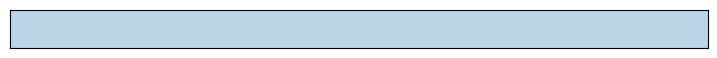

In [29]:
model.predict(results, kind="pps")
az.plot_separation(results, y='IsLaundering', figsize=(9,0.5)) # separation plot to assess model performance

In [22]:
# load model if saved as pickle

with open('saved/blr_model1_results.pickle', 'rb') as f:
    results = pickle.load(f)

In [28]:
new_data = model.predict(results, data=X_test, inplace=False)
new_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Warmup iterations saved (warmup_*).

In [33]:
# Get posterior mean across all chains and draws
p = new_data.posterior['IsLaundering_mean'].mean(("chain", "draw"))

model1_predict_df = pd.DataFrame()
model1_predict_df['true_label'] = y_test
model1_predict_df['prob'] = p.to_numpy()
model1_predict_df.reset_index(drop=True).to_csv('saved/bayesian_logistic_regression_model1_predict.csv', index=False)

In [31]:
y_prob = new_data.posterior['IsLaundering_mean'].mean(("chain", "draw"))
# define thresholds
thresholds = np.arange(0.001, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, get_predictions(new_data, y_mean_label='IsLaundering_mean', threshold=t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.999, F-Score=0.00225


Recall Score:  0.75
Precision Score:  0.001011804384485666
F1 score: 0.0020208824520040417
ROC AUC score: 0.5052583947072775
F-beta score: 0.005031868500503187


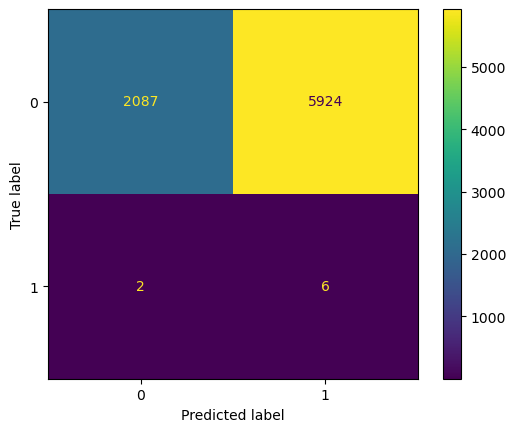

In [31]:
# Use best threshold value
y_pred1 = get_predictions(new_data, y_mean_label='IsLaundering_mean', threshold=0.498)

print('Recall Score: ', recall_score(y_test, y_pred1))
print('Precision Score: ', precision_score(y_test, y_pred1))

f1_result = f1_score(y_test, y_pred1)
print(f'F1 score: {f1_result}')

rocauc_result = roc_auc_score(y_test, y_pred1)
print(f'ROC AUC score: {rocauc_result}')

f2_result = fbeta_score(y_test, y_pred1, beta = 2)
print(f'F-beta score: {f2_result}')

cm = confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [34]:
# save model1 results
model1_results = open('saved/blr_model1_results.pickle', 'ab')
pickle.dump(results, model1_results)                    
model1_results.close()

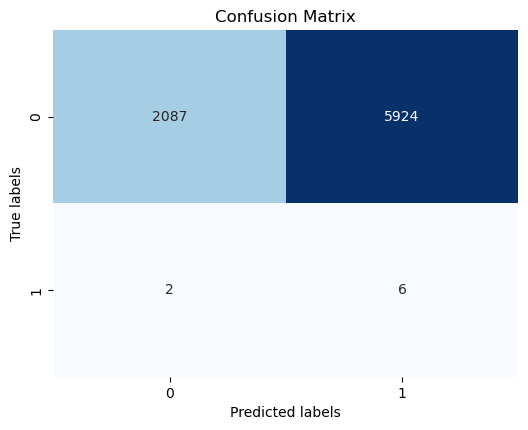

In [32]:
# save confusion matrix
plot_cm(y_test, y_pred1, outfile='saved/blr1_cm.png')

#### Model 2 - Prior Knowledge

In [33]:
formula = '''
            IsLaundering ~  FromBank 
                            +  ToBank 
                            +  ReceivingCurrency 
                            +  PaymentCurrency 
                            +  PaymentFormat 
                            +  AmountDeltaUSD 
                            +  LDAmountPaidUSD 
                            +  LDAmountReceivedUSD
'''

priors = {
    # 'FromBank': bmb.Prior("Categorical", p=FromBank_dist),
    # 'ToBank': bmb.Prior("Categorical", p=ToBank_dist),
    # 'ReceivingCurrency': bmb.Prior("Categorical", p=ReceivingCurrency_dist),
    # 'PaymentCurrency': bmb.Prior("Categorical", p=PaymentCurrency_dist),
    # 'PaymentFormat': bmb.Prior("Categorical", p=PaymentFormat_dist),
    'AmountDeltaUSD': bmb.Prior("LogNormal", mu=5),
    'LDAmountPaidUSD': bmb.Prior("Exponential", lam=0.3),
    'LDAmountReceivedUSD': bmb.Prior("Exponential", lam=0.3),
}

model2 = bmb.Model(formula, X_with_labels, priors=priors, family="bernoulli")
model2

       Formula: 
            IsLaundering ~  FromBank 
                            +  ToBank 
                            +  ReceivingCurrency 
                            +  PaymentCurrency 
                            +  PaymentFormat 
                            +  AmountDeltaUSD 
                            +  LDAmountPaidUSD 
                            +  LDAmountReceivedUSD

        Family: bernoulli
          Link: p = logit
  Observations: 32072
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 9.5013)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0007)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6061)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.6061)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.6421)
            AmountDeltaUSD ~ LogNormal(mu: 5.0)
            LDAmountPaidUSD ~ Exponential(lam: 0.3)
            LDAmountReceivedUSD ~ Ex

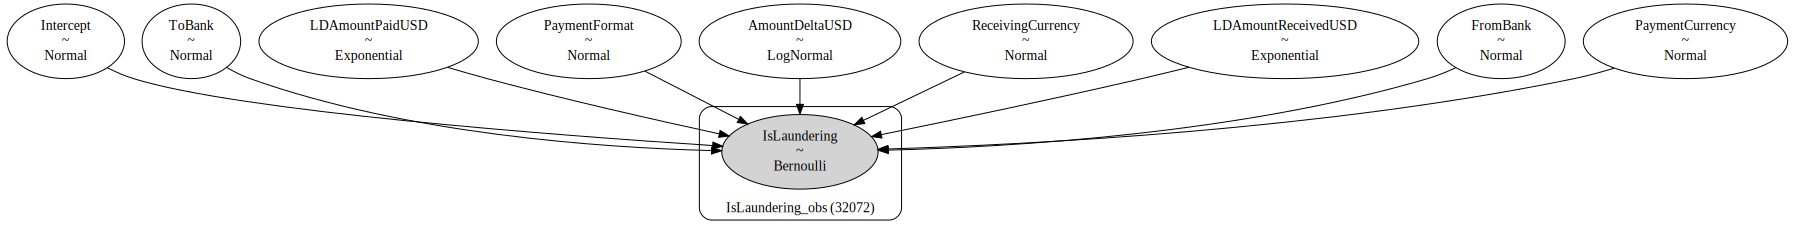

In [34]:
# Build model
model2.build()
model2.graph()

Sampling: [AmountDeltaUSD, FromBank, Intercept, LDAmountPaidUSD, LDAmountReceivedUSD, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToBank]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'ToBank'}>],
       [<Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentFormat'}>],
       [<Axes: title={'center': 'AmountDeltaUSD'}>,
        <Axes: title={'center': 'LDAmountPaidUSD'}>,
        <Axes: title={'center': 'LDAmountReceivedUSD'}>]], dtype=object)

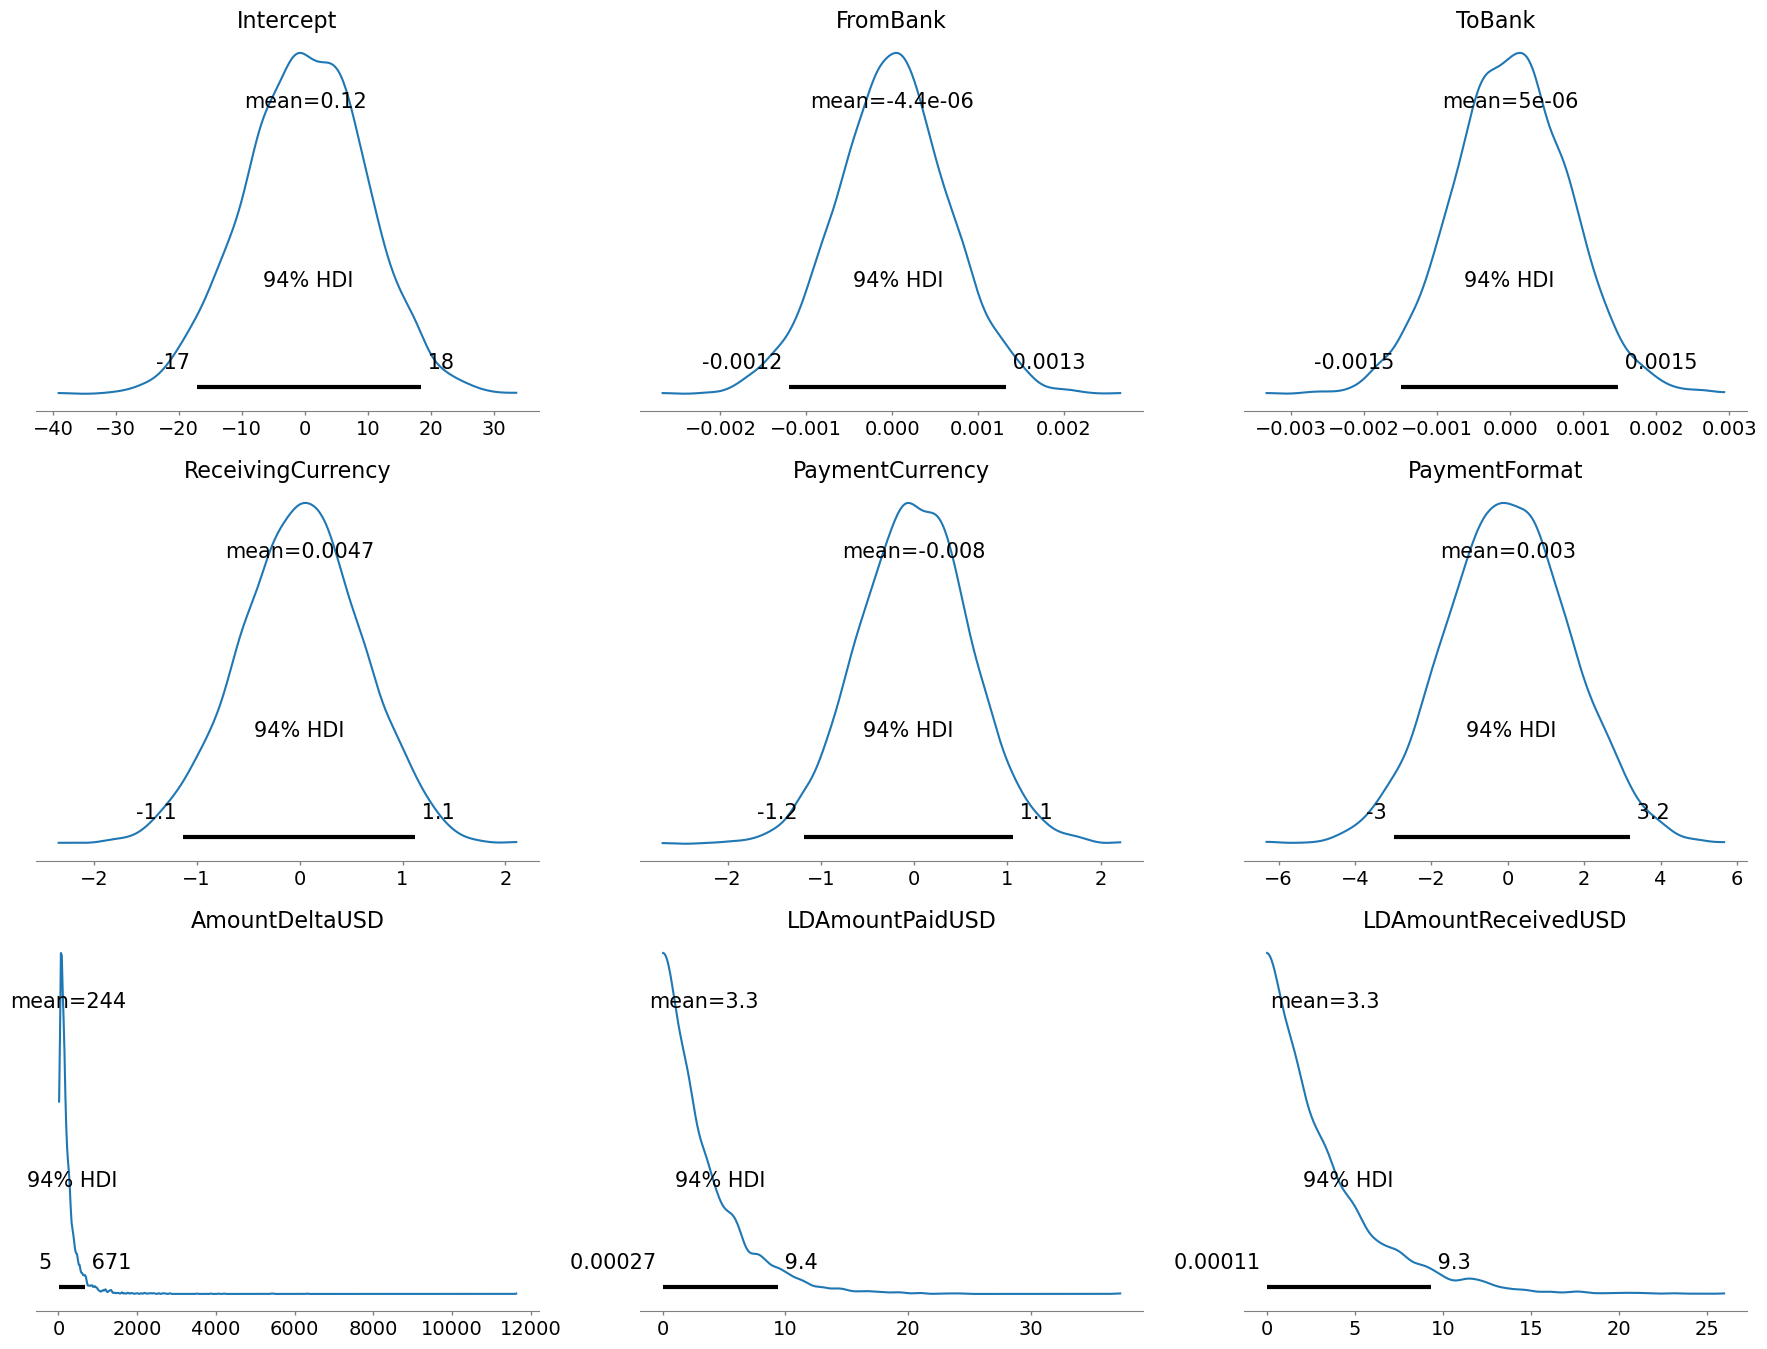

In [35]:
# Plot marginal priors of the built model
model2.plot_priors()

In [25]:
# fit the model
results2 = model2.fit(draws=1000, chains=2, nuts_sampler='nutpie', idata_kwargs={"log_likelihood": True})
# results2 = model2.fit(draws=1000, chains=2, inference_method='nuts_blackjax', idata_kwargs={"log_likelihood": True})

Modeling the probability that IsLaundering==1
/home/bernard/miniconda3/envs/pymc_env2/lib/python3.10/site-packages/pymc/sampling/mcmc.py:298: UserWarning: `idata_kwargs` are currently ignored by the nutpie sampler
  warnings.warn(


array([[<Axes: title={'center': 'AmountDeltaUSD'}>,
        <Axes: title={'center': 'AmountDeltaUSD'}>],
       [<Axes: title={'center': 'AmountDeltaUSD_log__'}>,
        <Axes: title={'center': 'AmountDeltaUSD_log__'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'LDAmountPaidUSD'}>,
        <Axes: title={'center': 'LDAmountPaidUSD'}>],
       [<Axes: title={'center': 'LDAmountPaidUSD_log__'}>,
        <Axes: title={'center': 'LDAmountPaidUSD_log__'}>],
       [<Axes: title={'center': 'LDAmountReceivedUSD'}>,
        <Axes: title={'center': 'LDAmountReceivedUSD'}>],
       [<Axes: title={'center': 'LDAmountReceivedUSD_log__'}>,
        <Axes: title={'center': 'LDAmountReceivedUSD_log__'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: 

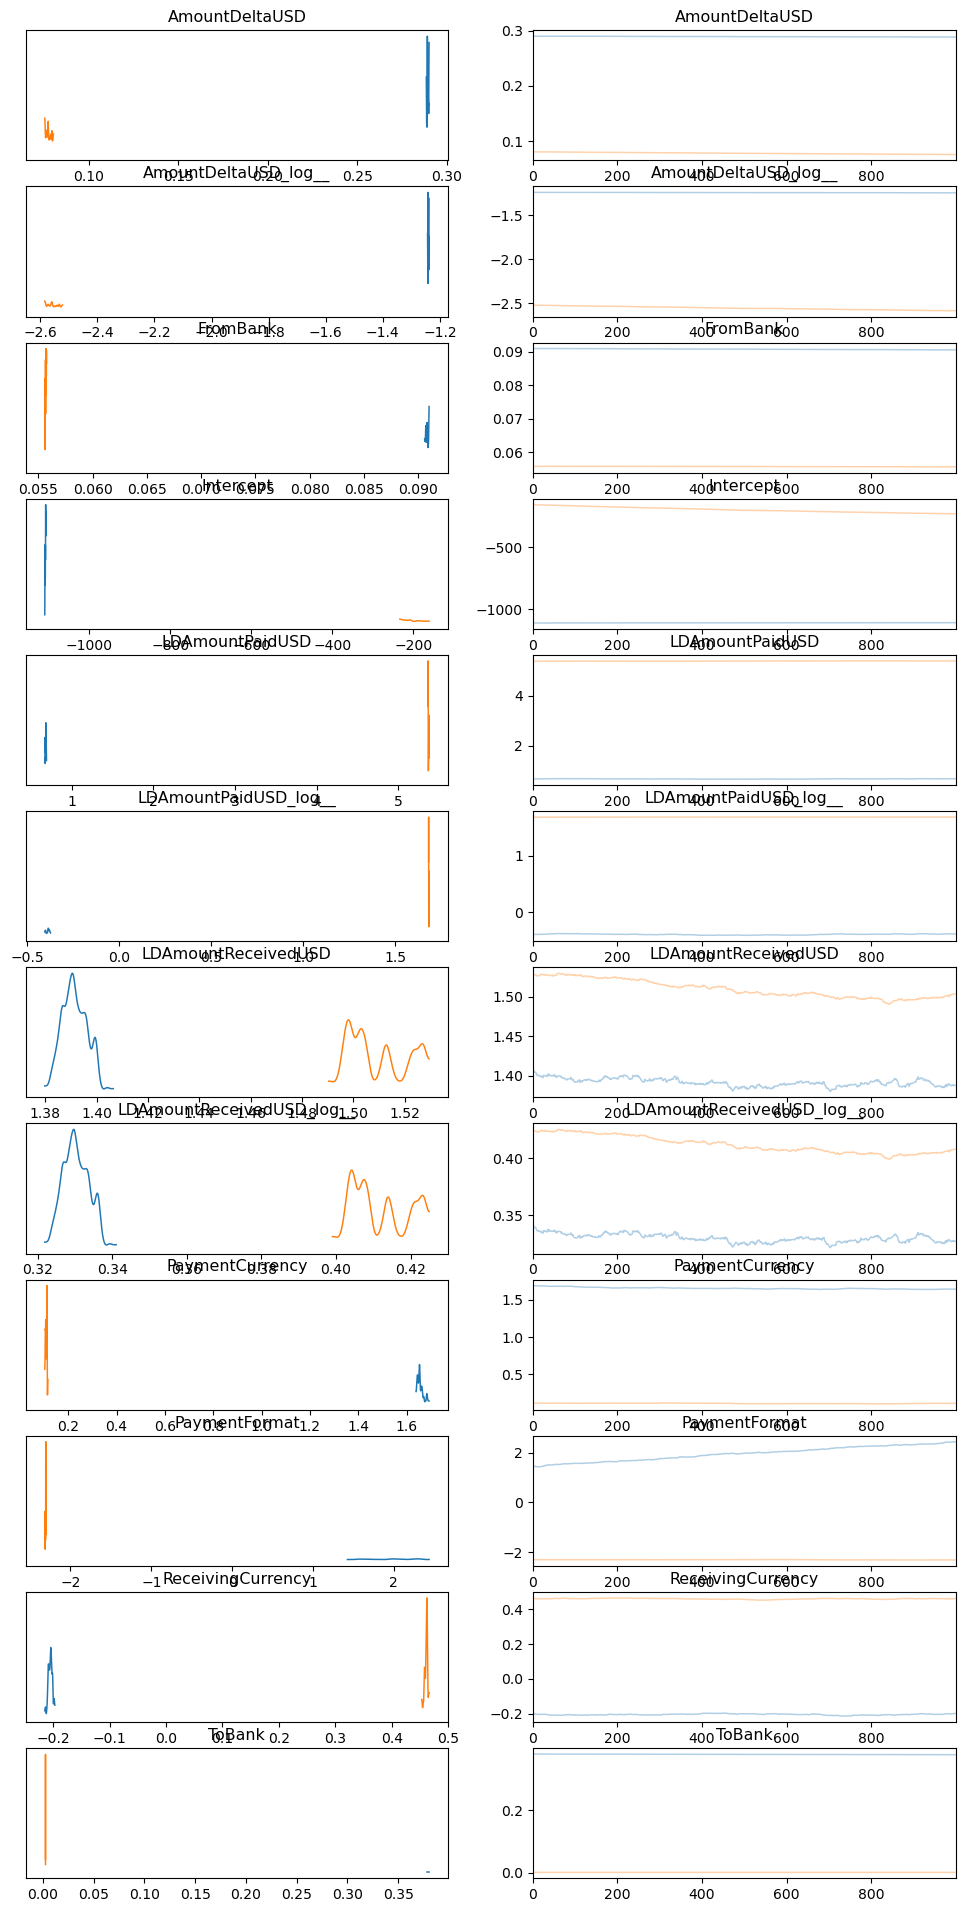

In [26]:
# traceplots and density estimates for the posteriors
az.plot_trace(results2, compact=False)

In [27]:
# summary of the posteriors
az.summary(results2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
AmountDeltaUSD,0.183,0.106,0.076,0.290,0.075,0.063,2.0,11.0,3.03
AmountDeltaUSD_log__,-1.898,0.658,-2.579,-1.238,0.463,0.392,2.0,11.0,3.03
FromBank,0.073,0.018,0.056,0.091,0.012,0.010,2.0,11.0,3.04
Intercept,-655.094,453.719,-1109.947,-172.341,319.507,270.314,2.0,11.0,3.04
LDAmountPaidUSD,3.026,2.347,0.670,5.379,1.653,1.398,3.0,22.0,2.23
LDAmountPaidUSD_log__,0.647,1.034,-0.400,1.683,0.728,0.616,3.0,22.0,2.23
LDAmountReceivedUSD,1.450,0.060,1.385,1.528,0.042,0.035,2.0,11.0,2.48
LDAmountReceivedUSD_log__,0.371,0.041,0.326,0.424,0.029,0.024,2.0,11.0,2.48
PaymentCurrency,0.883,0.774,0.103,1.672,0.545,0.461,2.0,11.0,2.80
PaymentFormat,-0.178,2.140,-2.318,2.313,1.506,1.273,2.0,11.0,2.40


In [36]:
# load model if saved as pickle

with open('saved/blr_model2_results.pickle', 'rb') as f:
    results2 = pickle.load(f)

In [37]:
# model predict
new_data2 = model2.predict(results2, data=X_test, inplace=False)

In [37]:
# Get posterior mean across all chains and draws
p = new_data2.posterior['IsLaundering_mean'].mean(("chain", "draw"))

model2_predict_df = pd.DataFrame()
model2_predict_df['true_label'] = y_test
model2_predict_df['prob'] = p.to_numpy()
model2_predict_df.reset_index(drop=True).to_csv('saved/bayesian_logistic_regression_model2_predict.csv', index=False)

In [29]:
# define thresholds
thresholds = np.arange(0.001, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, get_predictions(new_data2, y_mean_label='IsLaundering_mean', threshold=t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.462, F-Score=0.00208


Recall Score:  0.5
Precision Score:  0.001040582726326743
F1 score: 0.0020768431983385254
ROC AUC score: 0.5103295468730495
F-beta score: 0.005159958720330237


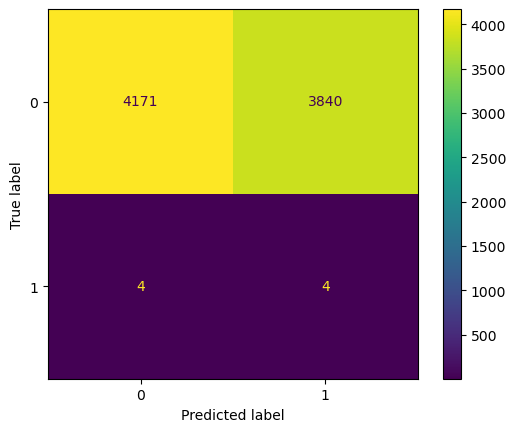

In [38]:
# Use best threshold value
y_pred2 = get_predictions(new_data2, y_mean_label='IsLaundering_mean', threshold=0.462)

print('Recall Score: ', recall_score(y_test, y_pred2))
print('Precision Score: ', precision_score(y_test, y_pred2))

f1_result = f1_score(y_test, y_pred2)
print(f'F1 score: {f1_result}')

rocauc_result = roc_auc_score(y_test, y_pred2)
print(f'ROC AUC score: {rocauc_result}')

f2_result = fbeta_score(y_test, y_pred2, beta = 2)
print(f'F-beta score: {f2_result}')

cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [40]:
# save model2 results
model2_results = open('saved/blr_model2_results.pickle', 'ab')
pickle.dump(results2, model2_results)                    
model2_results.close()

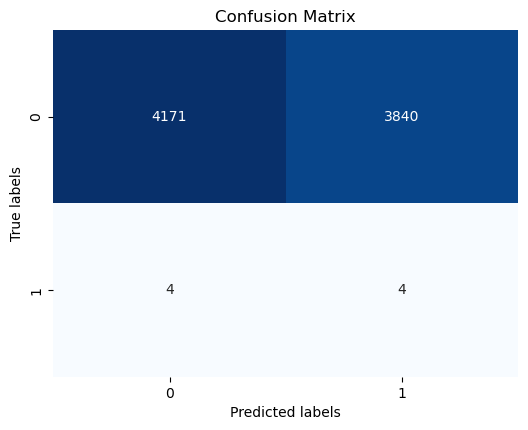

In [39]:
# save confusion matrix
plot_cm(y_test, y_pred2, outfile='saved/blr2_cm.png')

### Model Comparison

In [23]:
models_dict = {
    "model": results,
    "model2": results2
}
df_compare = az.compare(models_dict)
df_compare

/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work wel

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model,0,-349681.753098,321787.770686,0.000000,0.865115,2.075313e+03,0.000000,True,log
model2,1,-362554.791675,355445.874191,12873.038577,0.134885,7.195802e-13,2075.313253,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

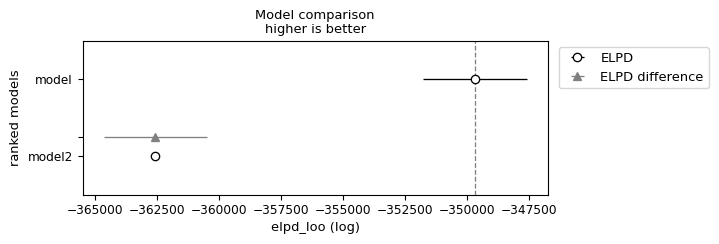

In [24]:
az.plot_compare(df_compare, insample_dev=False)

### Run inference

In [25]:
array = results.posterior["PaymentCurrency"].as_numpy()
array.shape

(2, 1000)

<Axes: >

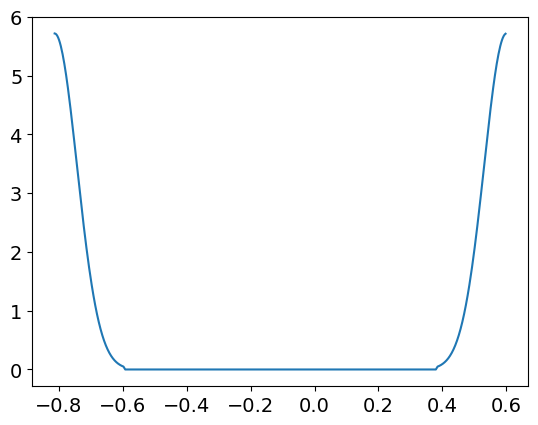

In [26]:
az.plot_dist(results.posterior["PaymentCurrency"])

<Axes: >

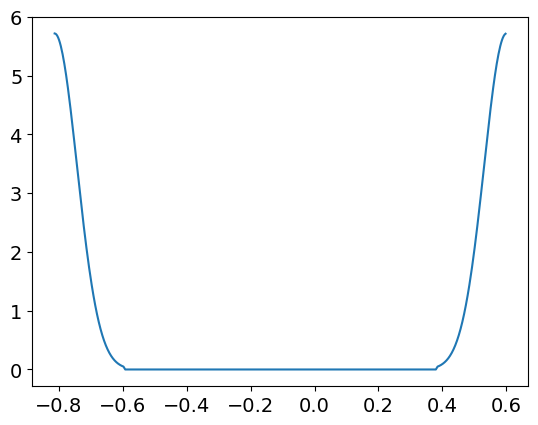

In [27]:
az.plot_dist(array)

### Model Prediction

(<Figure size 1200x500 with 4 Axes>,
 array([<Axes: title={'center': 'PaymentFormat = 0'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>,
        <Axes: title={'center': 'PaymentFormat = 1'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>,
        <Axes: title={'center': 'PaymentFormat = 3'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>,
        <Axes: title={'center': 'PaymentFormat = 6'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>],
       dtype=object))

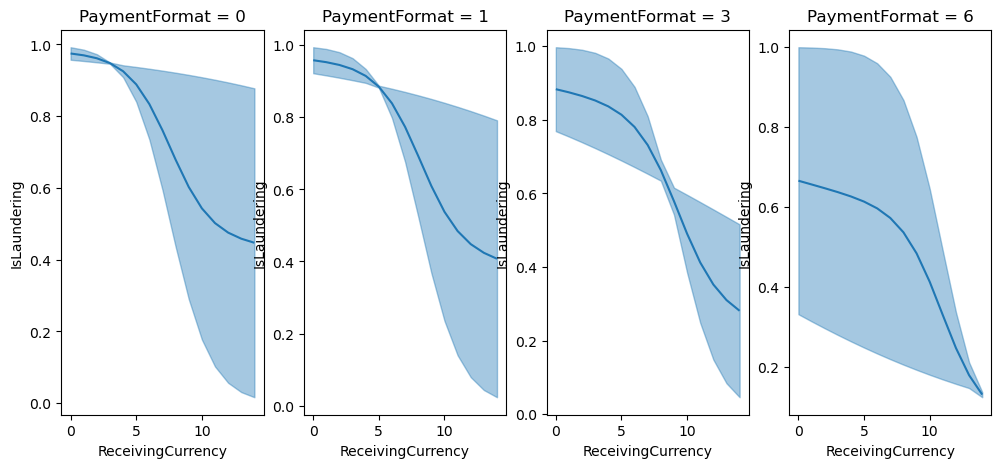

In [32]:
bmb.interpret.plot_predictions(
    model,
    results,
    ["ReceivingCurrency", "PaymentFormat"],
    subplot_kwargs={"main": "ReceivingCurrency", "group": "LDAmountReceived", "panel": "PaymentFormat"},
    fig_kwargs={"figsize": (12, 5)},
    legend=False
)

In [36]:
pred_df = bmb.interpret.predictions(
    model,
    results
)

pred_df.head(10)

,AmountPaid,AmountReceived,FromAccount,FromBank,LDAmountPaid,LDAmountReceived,PaymentCurrency,PaymentFormat,ReceivingCurrency,ToAccount,ToBank,estimate,lower_3.0%,upper_97.0%
690970,22134.180000,22134.180000,514607,7,2,2,6,2,6,149072,742,5.000000e-01,2.220446e-16,1.000000e+00
2193338,2025.430000,2025.430000,501340,24,2,2,12,4,12,29496,6047,5.000000e-01,2.220446e-16,1.000000e+00
511277,0.031935,0.031935,233926,46,3,3,1,1,1,61651,35,5.000000e-01,2.220446e-16,1.000000e+00
4986859,3687.580000,3687.580000,190960,831,3,3,12,4,12,503640,51,5.000000e-01,2.220446e-16,1.000000e+00
1599722,5005.460000,5005.460000,41364,629,5,5,4,3,4,125419,702,5.000000e-01,2.220446e-16,1.000000e+00
1101951,78.450000,78.450000,68000,645,7,7,12,4,12,64045,6146,5.000000e-01,2.220446e-16,1.000000e+00
1577862,506.690000,506.690000,439599,294,5,5,12,4,12,177386,0,5.000000e-01,2.220446e-16,1.000000e+00
3091344,2995.660000,2995.660000,501344,24,2,2,7,4,7,23602,6033,5.000000e-01,2.220446e-16,1.000000e+00
4183880,171.440000,171.440000,217755,6542,1,1,11,3,11,48904,6090,5.000000e-01,2.220446e-16,1.000000e+00
3985250,3655.270000,3655.270000,250145,874,3,3,4,4,4,182482,15,1.110223e-16,1.771746e-159,2.220446e-16


In [37]:
pred_df['estimate'].value_counts()

estimate
5.000000e-01    5003
5.000000e-01    4017
1.000000e+00     842
2.220446e-16     359
1.110223e-16      27
5.000007e-01       1
5.000021e-01       1
8.663627e-01       1
1.110223e-16       1
2.265476e-01       1
1.111527e-01       1
3.519591e-78       1
1.997291e-16       1
Name: count, dtype: int64